1.	Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2.	Построить случайный лес, вывести важность признаков
3.	Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
#from sklearn.svm import SVR
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('./house/train.csv')
dft=pd.read_csv('./house/test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# Колонки с нулевыми/отсутствующими значениями
col_nu=['LotFrontage','Alley','MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
        'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual',
        'GarageCond','PoolQC','Fence','MiscFeature']
print(len(col_nu))
# Колонки, где nan = отсутствие
col_na=['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2',
        'FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual', 'GarageCond',
        'PoolQC','Fence','MiscFeature']
# Колонки, где nan невыясненной природы
col_nan=['LotFrontage','MasVnrType','MasVnrArea','Electrical']
print(len(col_na),len(col_nan))

19
15 4


In [6]:
def na_to_no(df,cols):
    """
    NA to 'NoV' values in cols columns
    """
    df_out=df
    for each in cols:
        df_out[each].fillna('NoV',inplace=True)
    return df_out

In [7]:
df1=na_to_no(df,col_na)

In [8]:
df1['Electrical'].fillna(df1['Electrical'].mode()[0],inplace=True)
df1['MasVnrType'].fillna(df1['MasVnrType'].mode()[0],inplace=True)
df1['MasVnrArea'].fillna(df1['MasVnrArea'].mode()[0],inplace=True)

In [9]:
df1['LotFrontage'].fillna(round(df1['LotFrontage'].dropna().mean(),0),inplace=True)

In [10]:
# Колонки категориальных данных
col_cat=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
         'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
         'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
         'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType',
         'GarageFinish', 'PavedDrive', 
         'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
len(col_cat)

30

In [11]:
# Колонки с оценками
#1-5
col_eva1=['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']
#0-5
col_eva2=['BsmtQual', 'BsmtCond',  'FireplaceQu', 'GarageQual', 'GarageCond']
#0-4
col_eva3=['BsmtExposure']
#0-6
col_eva4=['BsmtFinType1', 'BsmtFinType2']
#0,2-5
col_eva5=['PoolQC']
print(len(col_eva1),len(col_eva2),len(col_eva3),len(col_eva4),len(col_eva5))

4 5 1 2 1


In [12]:
dict_={'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoV':0,'Av':3,'Mn':2,'No':1,'GLQ':6,
       'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
df1.replace(dict_, inplace=True)

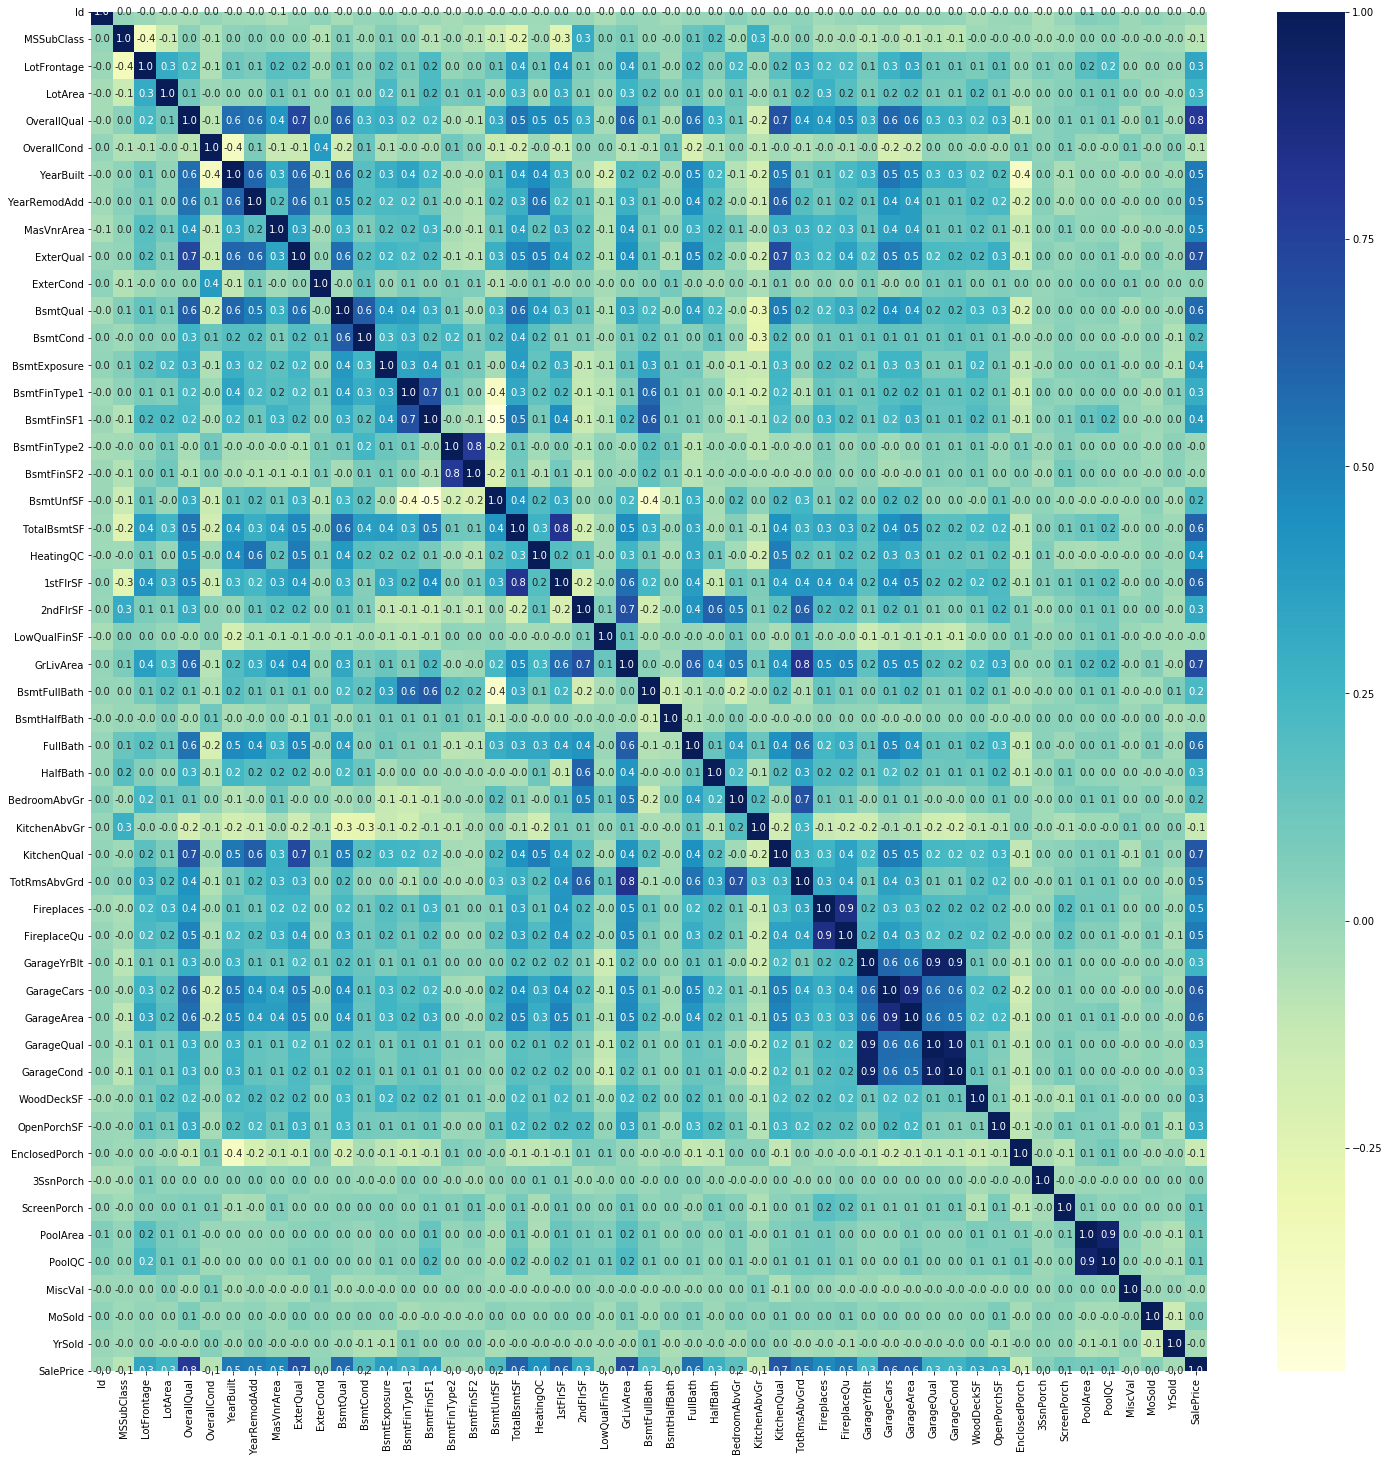

In [13]:
sns.heatmap(df1.corr(),annot=True,fmt='.1f',cmap="YlGnBu",xticklabels=True, yticklabels=True)
plt.gcf().set_size_inches(25,25)

In [14]:
X = df.select_dtypes(include=np.number).iloc[:,:-1]
y = df.select_dtypes(include=np.number)['SalePrice']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [50]:
#Выберем модели для стекинга. Выясним их качество по отдельности, затем объединим
rfr = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
lr = LinearRegression()
knr = KNeighborsRegressor()

In [51]:
rfr.fit(X_train,y_train)
rfr.score(X_test, y_test)

0.765207855742921

In [52]:
cross_val_score(rfr, X, y, cv=10)

array([0.8566742 , 0.83456085, 0.89664652, 0.81774365, 0.75705318,
       0.79450782, 0.825413  , 0.84815233, 0.70940584, 0.84630041])

In [53]:
pd.DataFrame(rfr.feature_importances_,
             index=X.columns,columns=['Importance']).sort_values('Importance',ascending=False)

,Importance
OverallQual,0.414212
GrLivArea,0.159582
GarageCars,0.154277
ExterQual,0.093832
GarageArea,0.030667
TotalBsmtSF,0.028141
KitchenQual,0.023257
1stFlrSF,0.019918
LotArea,0.019103
FireplaceQu,0.010476


In [54]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7095979525447793

In [55]:
cross_val_score(lr, X, y, cv=10)

array([0.87000126, 0.8742338 , 0.88894974, 0.75028727, 0.84412765,
       0.84439   , 0.83532023, 0.84167904, 0.534691  , 0.86484012])

In [56]:
knr.fit(X_train, y_train)
knr.score(X_test, y_test)

0.6017566803064509

In [57]:
cross_val_score(knr, X, y, cv=10)

array([0.6278126 , 0.66211983, 0.68887831, 0.71900513, 0.62097982,
       0.71408561, 0.71639028, 0.67380876, 0.4825362 , 0.63227708])

Объединим модели стекингом.

In [58]:
def get_meta_features(regr, X_train, y_train, X_test, y_test, stack_cv):
    
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        regr.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = regr.predict(X_train.iloc[test_ind])
        meta_test += regr.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [61]:
stack_cv = StratifiedKFold(n_splits=10, random_state=42)
meta_tr = []
meta_te = []
col_names = []

meta_tr_, meta_te_ = get_meta_features(lr, X_train, y_train, X_test, y_test, stack_cv)

meta_tr.append(meta_tr_)
meta_te.append(meta_te_)
col_names.append('lr_pred')

meta_tr_, meta_te_ = get_meta_features(rfr, X_train, y_train, X_test, y_test, stack_cv)

meta_tr.append(meta_tr_)
meta_te.append(meta_te_)
col_names.append('rfr_pred')

meta_tr_, meta_te_ = get_meta_features(knr, X_train, y_train, X_test, y_test, stack_cv)

meta_tr.append(meta_tr_)
meta_te.append(meta_te_)
col_names.append('sr_pred')

In [62]:
X_meta_train = pd.DataFrame(np.stack(meta_tr, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_te, axis=1), columns=col_names)

In [66]:
rfr_meta = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
rfr_meta.fit(X_meta_train, y_train)
rfr_meta.score(X_meta_test, y_test)

0.7882868573366225

В итоге, мы получили качество в стекинге лучше, чем случайный лес, лин. регрессия и kNN по отдельности.